In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive


In [ ]:
!pwd

/content/gdrive/My Drive


In [ ]:
from getpass import getpass
import os

user = getpass('User')
password = getpass('Password')
os.environ['GIT_AUTH'] = user + ':' + password

!git clone https://$GIT_AUTH@github.com/Ace95/DeepLearning_Project.git  

User··········
Password··········
Cloning into 'DeepLearning_Project'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 203217 (delta 41), reused 85 (delta 15), pack-reused 203103
Receiving objects: 100% (203217/203217), 1.44 GiB | 11.56 MiB/s, done.
Resolving deltas: 100% (393/393), done.
Checking out files: 100% (42058/42058), done.


In [ ]:
%cd /content/gdrive/My\ Drive/DeepLearning_Project/VGG19/

/content/gdrive/My Drive/DeepLearning_Project/VGG19


### General Imports and functions definitions

In [ ]:
"""
Created on Fri Apr 17 15:40:21 2020

@author: Nicolaas Ruberg
"""
import os
import pandas as pd
import matplotlib.pyplot as plt

def save_history(history,fileName):
    hist_df = pd.DataFrame(history)
    with open(fileName,mode='w') as f:
        hist_df.to_csv(f)

def save_elapsedTime(elapsedTime,fileName):
    f = open(fileName,'a+')
    f.write('%%Elapsed Time: {:.2f}m. \n'.format(elapsedTime/60))
    f.close()
        
def find_next_file_history(dirHistory, fileName):
    if not os.path.exists(dirHistory):
        os.makedirs(dirHistory)
    files = os.listdir(dirHistory)
    if len(files) > 0:
        for f in files:
            if f.endswith('.csv'):
                return (dirHistory+'/'+fileName[0:fileName.find('.')]
                        +'_' + str(len(files)) +'.csv')
            else:
                return (dirHistory+'/'+fileName)
    else:
        return (dirHistory+'/'+fileName)
    
def show_history(history):
    ACC = 'acc' # for keras
    VAL_ACC = 'val_acc'
    plt.plot(history.history[ACC]) 
    plt.plot(history.history[VAL_ACC])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')
    
    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'blue', label='Validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training loss', 'Validation loss'], loc='best')
    plt.savefig('./models/plot_history.png')
    plt.show()
    # Let's save our result for further analysi
  
    

## Defining initial parameters

In [ ]:
import time
import keras
import pandas as pd
import matplotlib.pyplot as plt
from numpy import asarray
from keras.utils import to_categorical
from keras.preprocessing.image  import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers
#from  myUtils import find_next_file_history, save_history, show_history, save_elapsedTime



trainDIR='../source_light/train'
valDIR='../source_light/valid'
testDIR='../source_light/test'
# imgHeight=224 #218
# imgWidth=224 #178
imgHeight=218
imgWidth=178
imageShape=(imgHeight,imgWidth) #Celeba croped image shape

histFileName = 'historyVGG19_src_light.csv'
dirHistFileName = './history'

numEpochs=20

In [ ]:
vgg = VGG19(input_shape=imageShape+(3,), include_top = False, weights = "imagenet", classes = 1000,
                            backend=keras.backend, layers=keras.layers,
                            models=keras.models,utils=keras.utils) # this line imports the VGG19 model trained on imagenet dataset and discard the last 1000 neurons layer 

output=vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input,output)

# We want to use the pre-trained weights
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
        
##
input_shape = vgg_model.output_shape[1]

model = keras.models.Sequential()
model.add(vgg_model)
model.add(keras.layers.InputLayer(input_shape=(input_shape,)))
model.add(Dense(512,activation='relu',input_dim=input_shape))
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])
print(model.summary())


layers = [(layer.name, layer.trainable) for layer in model.layers]
print(pd.DataFrame(layers, columns=['Layer Name', 'Layer Trainable']))


80142336/80134624 [==============================] - 8s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 15360)             20024384  
_________________________________________________________________
input_2 (InputLayer)         (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               7864832   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_______________________________________________________

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_it = train_datagen.flow_from_directory(
    directory=trainDIR,
    target_size=imageShape,
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

val_it = train_datagen.flow_from_directory(
    directory=valDIR,
    target_size=imageShape,
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

FileNotFoundError: ignored

In [ ]:
start = time.time()
step_size_train = train_it.n//train_it.batch_size
step_size_val = val_it.n//val_it.batch_size

history = model.fit_generator(generator=train_it,steps_per_epoch=step_size_train,
                    epochs=numEpochs,
                    validation_data=val_it,
                    validation_steps=step_size_val
                    )


model.save('./models/VGG19_celeba_model_src_light.h5')

##    
end = time.time()
elapsedTime= (end - start)
print('Elapsed Time:')
print("\t\t{:.2f}m".format(elapsedTime/60))

Epoch 1/20
343/343 [==============================] - 58s 170ms/step - loss: 1.4800 - acc: 0.5136 - val_loss: 1.1841 - val_acc: 0.4970
Epoch 2/20
343/343 [==============================] - 61s 178ms/step - loss: 1.3252 - acc: 0.5137 - val_loss: 1.0554 - val_acc: 0.5031
Epoch 3/20
343/343 [==============================] - 61s 179ms/step - loss: 1.2393 - acc: 0.5170 - val_loss: 0.9372 - val_acc: 0.4752
Epoch 4/20
343/343 [==============================] - 61s 178ms/step - loss: 1.1312 - acc: 0.5178 - val_loss: 1.0673 - val_acc: 0.4876
Epoch 5/20
343/343 [==============================] - 61s 177ms/step - loss: 1.1715 - acc: 0.5161 - val_loss: 1.1421 - val_acc: 0.5134
Epoch 6/20
343/343 [==============================] - 61s 179ms/step - loss: 1.1326 - acc: 0.5163 - val_loss: 0.9110 - val_acc: 0.4855
Epoch 7/20
343/343 [==============================] - 61s 178ms/step - loss: 1.1820 - acc: 0.5191 - val_loss: 0.9686 - val_acc: 0.4721
Epoch 8/20
343/343 [==============================] - 6

In [ ]:
val_test = train_datagen.flow_from_directory(
    directory=testDIR,
    target_size=imageShape,
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)


step_size_val = val_test.n//val_test.batch_size
score1 = model.evaluate_generator(generator=val_test,steps=step_size_val)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Found 1000 images belonging to 3 classes.
Test loss: 1.095521092414856
Test accuracy: 0.5372983813285828


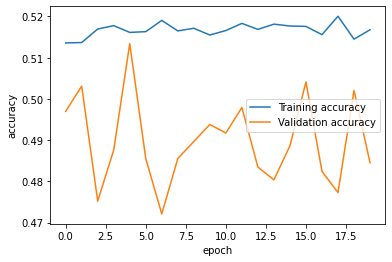

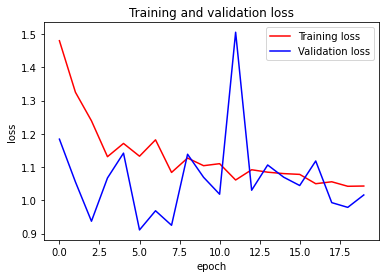

In [ ]:
show_history(history)
finalHistoryFile=find_next_file_history(dirHistFileName,histFileName)
save_history(history.history,finalHistoryFile)

save_elapsedTime(elapsedTime,finalHistoryFile)


In [ ]:
# Final execution with 10 epochs
numEpochs = 10
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size
history = cnn4.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=numEpochs,
                    validation_data=val_generator,validation_steps=step_size_val)

cnn4.save('./models/VGG19_celeba_model-10epochs.h5')
end = time.time()
elapsedTime= (end - start)
print("Elapsed Time:")
print("\t\t{:.2f}m".format(elapsedTime/60))